### Reading And Scaling An Image From A Thermal Camera

Read frames over RTSP and scale to temperature values using SUNAPI for Wisenet cameras 

In [1]:
import cv2
from matplotlib import pyplot as plt
import time
import numpy as np
import datetime
import pandas as pd 
import gc
import pickle
import requests
from requests.auth import HTTPBasicAuth, HTTPDigestAuth

%matplotlib inline

In [4]:
def calibrate_frame(cframe, addr, uname, passwd):
    """
    Given a frame query the SUNAPI for the 4030TR Camera to get two points and scale
    pixel values to temperatures. Assumes (correctly?) linearity.
    
    Parameters
    ----------
    cframe: Array
       frame to be callibrated
    addr: String
       IP address of the camera
    uname: String
       Username
    passwd: String
       Password
    
    Returns
    -------
    calframe: Array
       Calibrated frame
    
    """
    #Construct request
    req_addy = 'http://' + addr + '/stw-cgi/image.cgi'
    
    #Find pixel locations and values for coldest and hottest pixels
    hottest = np.where(cframe == cframe.max())
    hottest_value = cframe[hottest[0][0], hottest[1][0]]
    coldest = np.where(cframe == cframe.min())
    coldest_value = cframe[coldest[0][0], coldest[1][0]]

    #use requests to call the API
    base_query = {'msubmenu':'spottemperaturereading', 'action':'view','Channel':'0',
             'ScreenResolution' : '640x480'}

    #Fetch temperature for hottest pixel
    base_query.update({'ScreenCoordinates' : str(hottest[1][0])+',' + str(hottest[0][0])})
    response = requests.get(req_addy, params=base_query, 
                            auth=HTTPDigestAuth(uname, passwd))

    hot = float(response.json()['SpotTemperatureReading'][0]['Temperature'])
    
    #Fetch temperature value for coldest pixel
    base_query.update({'ScreenCoordinates' : str(coldest[1][0])+',' + str(coldest[0][0])})
    response = requests.get(req_addy, params=base_query, 
                            auth=HTTPDigestAuth(uname, passwd))
    cold = float(response.json()['SpotTemperatureReading'][0]['Temperature'])

    #Assume form Y=MX+B, M is d_temperature/d_pixelval 
    dpixdt = (hot-cold)/(hottest_value - coldest_value)
    b = cold - dpixdt*coldest_value

    #calibrate
    calframe = cframe*dpixdt + b
    
    return calframe

def get_thermal(addr, uname, passwd, dt=0.1, nf=5):
    """
    And calibrate nf number of frames spaced by dt seconds from a 4030TR camera and calibrate.
    
    Parameters
    ----------
    addr: String
       IP address of the camera
    uname: String
       Username
    passwd: String
       Password
    dt: Float
       (Optional) Time between frames in seconds
    nf: Integer
       (Optional) Number of frames
    
    Returns
    -------
    frames: Array
       an array of shape nf,480,640 with a burst of nf calibrated frames
    
    """
    times = []
    frames = np.zeros((nf,480,640))
    rtsp = 'rtsp://' + uname + ':' + passwd + '@' + addr + '/barry/media.SMP'
    for j in range(nf):
        capture = cv2.VideoCapture(rtsp)
        times.append(np.datetime64('now'))
        ret, frame = capture.read()
        frames[j,:] =  calibrate_frame(frame.mean(axis=2), addr, uname, passwd)
        time.sleep(dt)
    
    return frames, np.array(times)
    

In [5]:
fr, tms = get_thermal('0.0.0', 'admin', 'sillypassword', nf=3)

/Users/scollis/miniconda3/envs/cv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


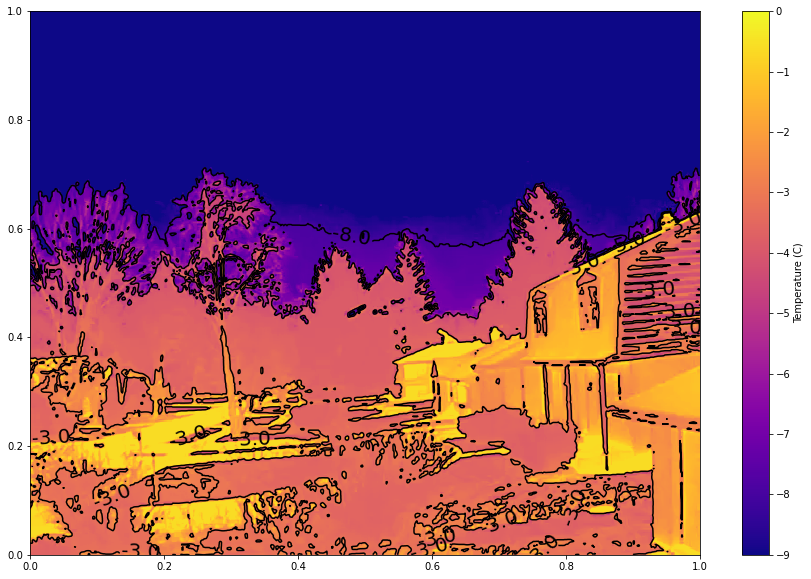

In [20]:
fig = plt.figure(figsize=[15,10])
pc = plt.pcolormesh(np.linspace(0,1,640), np.linspace(1,0,480), fr[0], vmin = -9, vmax = 0,
              cmap='plasma')

cs = plt.contour(np.linspace(0,1,640), np.linspace(1,0,480), fr[0], levels =[-10, -8, -5, -3], colors=['k','k', 'k'])

plt.gca().clabel(cs, inline=1, fontsize=20, fmt='%1.1f')
cb = plt.colorbar(mappable = pc)
cb.set_label('Temperature (C)')